In [8]:
import argparse
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

In [12]:
class MLP(nn.Module):
    def __init__(self, image_channels=1, hidden_size=128, hidden_layers=3):
        super().__init__()
        self.initial_conv = ConvBlock(image_channels, hidden_size, kernel_size=7, stride=2, padding=3)
        self.conv_blocks = nn.Sequential(*[ConvBlock(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
        self.upsample = nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1)  
        self.final_conv = nn.Conv2d(hidden_size, image_channels, kernel_size=3, stride=1, padding=1)

        # ajouter des linear ( MLP ) pour le label 
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.conv_blocks(x)
        x = self.upsample(x)  # Application de l'upsample
        x = self.final_conv(x)
        return x



In [14]:
def train_bis(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        
        for noise_factor in np.arange(0.4, 4, 0.2):
            
            noise = torch.randn_like(data) * noise_factor 
            
            noisy_data = data + noise
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
def train_bis_bis(model, dataloader, optimizer, device, config):

    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        noisy_data_pred = data
        for i in range(10):
            noise = torch.randn_like(data) * 0.5
            
            noisy_data_pred = noisy_data
            
            noisy_data = noisy_data_pred + noise
            
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, noisy_data_pred)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
def train_param(model, dataloader, optimizer, device, config):
    noise_scheduler = NoiseScheduler(
        num_timesteps=config.num_timesteps,
        beta_schedule=config.beta_schedule)

    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, _) in tqdm(enumerate(dataloader)):
        
        for noise_factor in np.arange(0.1, 1, 0.1):
            # noise factor = lambda 
            
            noise = torch.randn_like(data) * noise_factor 
            noisy_data = (1 - noise_factor) * data + noise
            
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()

            # Le modèle essaie de débruiter l'image
            output = model(noisy_data)

            # Calculer la perte par rapport aux images originales non bruitées
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
def main(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    for epoch in range(config.num_epochs):
        loss = train_param(model, dataloader, optimizer, device,config) # train à choisir 
        print(f"Epoch: {epoch+1}, Loss: {loss}")

    # Sauvegarder le modèle
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(), f"models/mnist_model_param.pth") # Nom à changer à chaque fois 


'if __name__ == "__main__":\n    parser = argparse.ArgumentParser()\n    parser.add_argument("--train_batch_size", type=int, default=32)\n    parser.add_argument("--num_epochs", type=int, default=10)\n    parser.add_argument("--learning_rate", type=float, default=1e-3)\n    config = parser.parse_args()\n\n    main(config)'

In [18]:
config = Config()
main(config)

1875it [00:44, 42.30it/s]


Epoch: 1, Loss: 0.8234397842027247


1875it [00:44, 41.93it/s]


Epoch: 2, Loss: 0.7665982810767988


1875it [00:44, 42.50it/s]


Epoch: 3, Loss: 0.7569211384297659


1875it [00:44, 42.54it/s]


Epoch: 4, Loss: 0.7518727274989089


1875it [00:44, 42.52it/s]


Epoch: 5, Loss: 0.7491453651738663


1875it [00:44, 42.42it/s]


Epoch: 6, Loss: 0.7464581331506371


1875it [00:44, 42.35it/s]


Epoch: 7, Loss: 0.744635657640174


1875it [00:44, 42.38it/s]


Epoch: 8, Loss: 0.7435827865927169


1875it [00:44, 42.41it/s]


Epoch: 9, Loss: 0.7417325310749312


1875it [00:44, 42.49it/s]


Epoch: 10, Loss: 0.7408400376149764


1875it [00:43, 42.74it/s]


Epoch: 11, Loss: 0.7406881579466165


1875it [00:43, 42.75it/s]


Epoch: 12, Loss: 0.7396625354796648


1875it [00:44, 42.40it/s]


Epoch: 13, Loss: 0.738823534400637


1875it [00:43, 42.83it/s]


Epoch: 14, Loss: 0.7392799187795569


1875it [00:43, 42.98it/s]

Epoch: 15, Loss: 0.7380184020750225


In [43]:
class Config:
    train_batch_size = 32
    num_epochs = 15
    learning_rate = 1e-3
    num_timesteps = 50
    beta_schedule = "linear"
    eval_batch_size = 1000
    image_size =28
    

MLP(
  (initial_conv): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
  (upsample): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([5, 1, 28, 28])


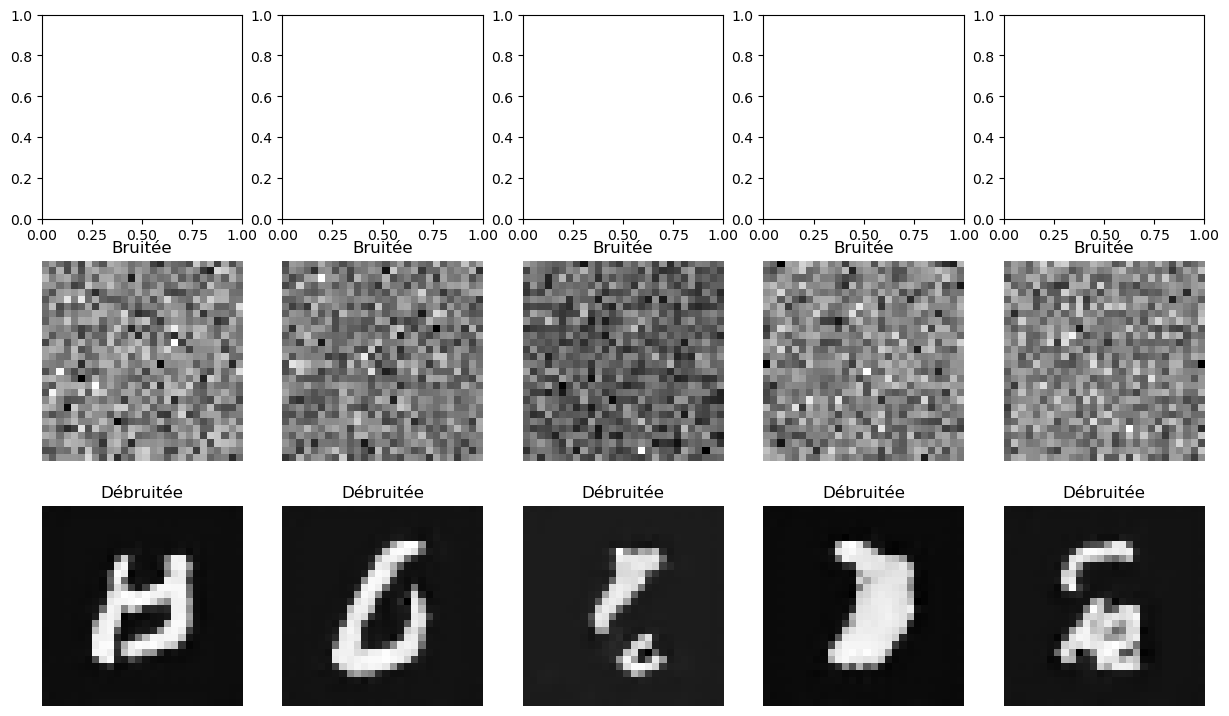

In [42]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)


model = MLP()
model.load_state_dict(torch.load('models/mnist_model_param.pth'))

# Afficher l'architecture du modèle
print(model)

# Prendre 5 images du dataset MNIST et les bruiter

images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images = model(noisy_images)
denoised_images = model(denoised_images)


print(denoised_images.shape)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    """axs[0, i].imshow(images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Original')
    axs[0, i].axis('off')"""
    
    axs[1, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bruitée')
    axs[1, i].axis('off')

    axs[2, i].imshow(denoised_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée')
    axs[2, i].axis('off')

plt.show()



MLP(
  (initial_conv): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
  (upsample): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([5, 1, 28, 28])


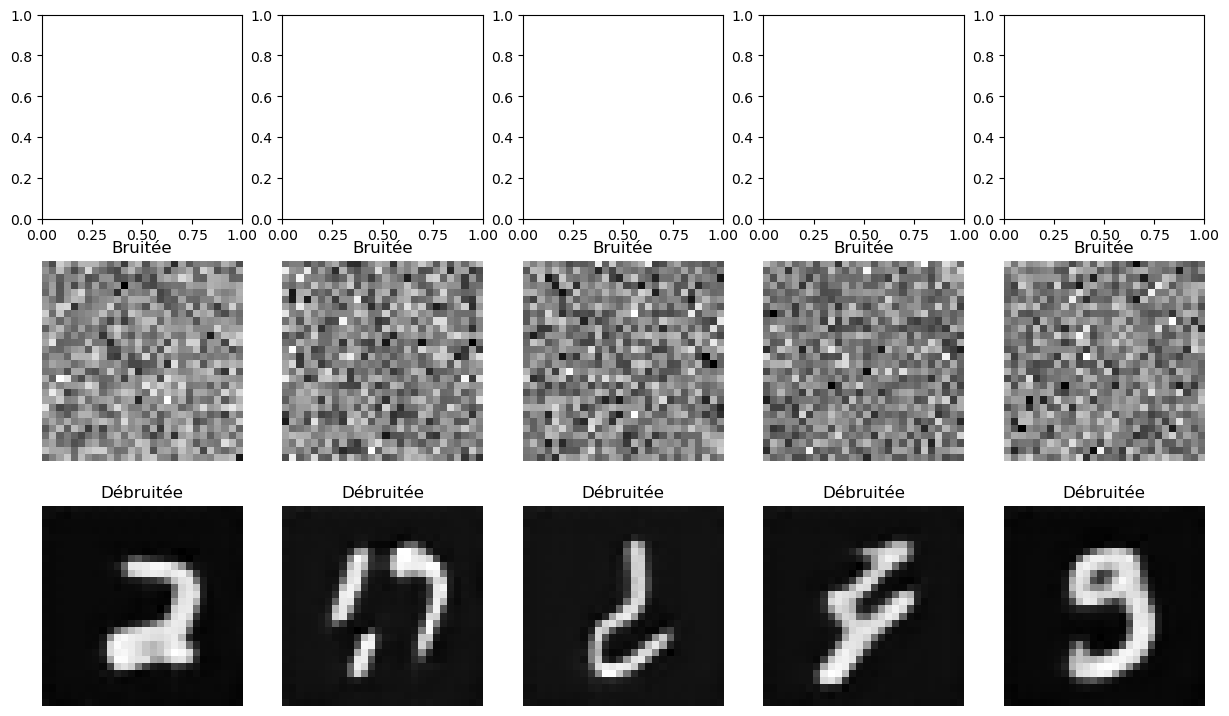

In [36]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)


model = MLP()
model.load_state_dict(torch.load('models/mnist_model_train_bis_0.2_15.pth'))

# Afficher l'architecture du modèle
print(model)

# Prendre 5 images du dataset MNIST et les bruiter
images, labels = next(iter(mnist_loader))
#noisy_images = images + 3* torch.randn_like(images)  # Ajout d'un bruit gaussien
noisy_images = 0.5*torch.randn_like(images)

denoised_images = model(noisy_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)
denoised_images = model(denoised_images)

print(denoised_images.shape)

fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    """axs[0, i].imshow(images[i].squeeze().detach().numpy(), cmap='gray')
    axs[0, i].title.set_text('Original')
    axs[0, i].axis('off')"""
    
    axs[1, i].imshow(noisy_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[1, i].title.set_text('Bruitée')
    axs[1, i].axis('off')

    axs[2, i].imshow(denoised_images[i].squeeze().detach().numpy(), cmap='gray')
    axs[2, i].title.set_text('Débruitée')
    axs[2, i].axis('off')

plt.show()

